# Ensemble Learning through Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [3]:
!git clone https://github.com/tlpss/ML-Project2.git

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *


fatal: destination path 'ML-Project2' already exists and is not an empty directory.


## Parameter Configuration

In [4]:
np.random.seed(2020)

In [5]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [6]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [7]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [8]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [9]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  


In [10]:
## calculate V_0 separately using bigger dataset
s_v =MaxCallStochasticModel(200000, d, [1/12,11/12])
s_v.generate_samples()
V_0 = s_v.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0794089095719135

In [12]:
X_test.shape

(50000, 1, 2)

## Create Custom Models
(to have more control of splitting etc)

In [13]:
from aggregating.models import SimpleBagger
s = SimpleBagger(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [25]:
#reference:
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0} #baseline!
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],3,N_test,MaxCallStochasticModel,V_0)
print(reference_error)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 139877870290816
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.13961571842654963
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.1439832429698755
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.16041179271720074
{'M': 1, 'train_size_alpha': 1.0} -> [0.13961571842654963, 0.1439832429698755, 0.16041179271720074]
[0.13961571842654963, 0.1439832429698755, 0.16041179271720074]


In [26]:
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

0.14800358470454197


In [19]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [5,7,9,11,13]
alpha_grid = [0.01,0.05,0.1,0.3,0.5]
results = []
print(cpu_count())
### ACTUAL GRIDSEARCH
pool = ThreadPool(2) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



2
 {'M': 5, 'train_size_alpha': 0.01} -> thread id = 139877156321024
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.05} -> thread id = 139877147928320
fit
(5000, 2)
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 0 -> 0.3466503938926859
predict
(50000, 2)
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 1 -> 0.34518758018014845
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 2 -> 0.33787928815715446
{'M': 5, 'train_size_alpha': 0.01} -> [0.3466503938926859, 0.34518758018014845, 0.33787928815715446]
 {'M': 5, 'train_size_alpha': 0.1} -> thread id = 139877156321024logger {'M': 5, 'train_size_alpha': 0.01}, -> [0.3466503938926859, 0.34518758018014845, 0.33787928815715446]

fit
(5000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 0 -> 0.23575809127419792
predict
(50000, 2)
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 1 -> 0.2401477269329611
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 2 -> 0.2516913382045895
{'M': 5, 'train_size_alpha': 0.05} -> [0.235

In [20]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[5, 0.01, [0.3466503938926859, 0.34518758018014845, 0.33787928815715446]]
[5, 0.05, [0.23575809127419792, 0.2401477269329611, 0.2516913382045895]]
[5, 0.1, [0.23653601852051814, 0.24028719518238262, 0.2402101974387289]]
[5, 0.3, [0.16663773158870523, 0.15073769987843677, 0.12333443036325216]]
[7, 0.01, [0.2324867287491356, 0.2234221388280565, 0.2166417868183079]]
[7, 0.05, [0.1376348780469928, 0.12899084150981455, 0.12776062628176607]]
[7, 0.1, [0.20199667277414457, 0.18362461733337276, 0.1914501637219048]]
[5, 0.5, [0.18207463478674935, 0.17654978145063632, 0.17170728213400863]]
[7, 0.3, [0.13743482207704288, 0.13541372506132685, 0.13569909412464956]]
[9, 0.01, [0.2421206492105991, 0.25912898506445, 0.25847866747386977]]
[9, 0.05, [0.18352472723127483, 0.1814066812091378, 0.20225409093659943]]
[9, 0.1, [0.20162013723956582, 0.21134638881675438, 0.19458218438497213]]
[7, 0.5, [0.17155959711029484, 0.1742179369934229, 0.16172985594179354]]
[9, 0.3, [0.15415947240327718, 0.11321835959172

In [21]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 5)

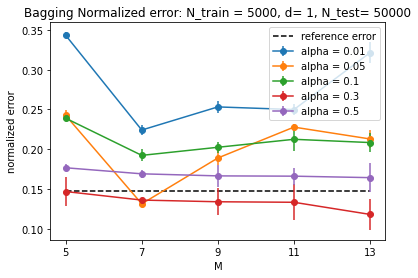

In [27]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## Store results

In [ ]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [ ]:
import json
import datetime
with open(f'#0005_hard_bagging_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)